In [101]:
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
import joblib

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
from src.Bayesian_state import *
from src.Bayesian_state.problems.config import config_fgt
from src.Bayesian_state.problems import *
# from src.Bayesian_state.utils.optimizer import Optimizer, ConstantDict
# from src.Bayesian_state.utils.model_evaluation import ModelEval

In [103]:
processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')

subject_id = 8
subject_data = learning_data[learning_data["iSub"] == subject_id]
condition = subject_data["condition"].iloc[0]
s_data = (
    subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
    subject_data["choice"].values,
    subject_data["feedback"].values
)
print(condition)

2


In [104]:
subject_data.keys()

Index(['iSub', 'version', 'condition', 'structure1', 'structure2', 'iSession',
       'iBlock', 'iTrial', 'neck_length', 'head_length', 'leg_length',
       'tail_length', 'neck_angle', 'head_angle', 'leg_angle', 'tail_angle',
       'feature1', 'feature2', 'feature3', 'feature4', 'category', 'choice',
       'feedback', 'ambigous', 'choRT', 'neck_oral', 'head_oral', 'leg_oral',
       'tail_oral', 'text', 'feature1_oral', 'feature2_oral', 'feature3_oral',
       'feature4_oral', 'neck_use', 'head_use', 'leg_use', 'tail_use',
       'feature1_use', 'feature2_use', 'feature3_use', 'feature4_use'],
      dtype='object')

In [105]:
beta_range = (1, 30)
beta_resolution = 5
beta_grid = np.linspace(beta_range[0], beta_range[1], beta_resolution)

In [106]:
from src.Bayesian_state.problems import StandardModel, StateModel
from src.Bayesian_state.utils.load_config import MODEL_STRUCT

# 打印字典并排版
import pprint
pprint.pprint(MODEL_STRUCT)

model = StateModel(MODEL_STRUCT['pm_model'],condition=condition)

INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.
INFO:cat-learning:  - Module 'perception_mod' registered as 'self.perception_mod'.


{'base_model': {'agenda': ['likelihood_mod', '__self__'],
                'modules': {'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule',
                                               'kwargs': {}}}},
 'default_model': {'agenda': ['__self__'], 'modules': {}},
 'm_model': {'agenda': ['likelihood_mod', 'memory_mod'],
             'modules': {'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule',
                                            'kwargs': {}},
                         'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule',
                                        'kwargs': {'gamma': 0.8, 'w0': 0.2}}}},
 'p_model': {'agenda': ['perception_mod', 'likelihood_mod', '__self__'],
             'modules': {'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule',
                                            'kwargs': {}},
                

In [107]:
# 按trial重整数据
input_data = []
trial_total_num = subject_data.shape[0]
for i in range(trial_total_num):
    input_data.append([s_data[0][i],s_data[1][i], s_data[2][i]])


print(input_data[:5])  # 打印前5个trial

[[array([0.55510771, 0.71195211, 0.82230859, 0.36544391]), np.int64(2), np.float64(0.0)], [array([0.23835853, 0.15970855, 0.02914874, 0.48871775]), np.int64(2), np.float64(0.0)], [array([0.15850176, 0.11336038, 0.31999058, 0.15477384]), np.int64(3), np.float64(0.0)], [array([0.35738885, 0.73203445, 0.10123849, 0.41912233]), np.int64(3), np.float64(0.0)], [array([0.02072851, 0.06976594, 0.53048036, 0.79514644]), np.int64(1), np.float64(1.0)]]


In [108]:
results_state = model.fit_step_by_step(input_data, beta=30)

In [109]:
np.asarray(results_state).argmax(axis=1)

array([ 63,  30,  27,  79,  11,  84, 112, 112, 112, 112, 112, 112, 112,
         9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,
       107, 107,  43,  43,  43,  43,   5,   5,   5,   9,   9,   9,   9,
         9,   9,   9,   9,   9,   9,  24,  24,  70,  70,  70,  36,  36,
        36,  11,  95, 100,  10,  95,  95,  95,  95,  10,  10,  10,  10,
        10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,
        10,  10,  10,  10,  10,  10,   8,  10,  10,  10,  10,  10,  10,
        10,  10,  11,  11,  11,  11,  11,  11,  10,  10,  10,  10,  10,
        10,  10,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,
        11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,
        11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,
        11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,
        11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,
        11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  1

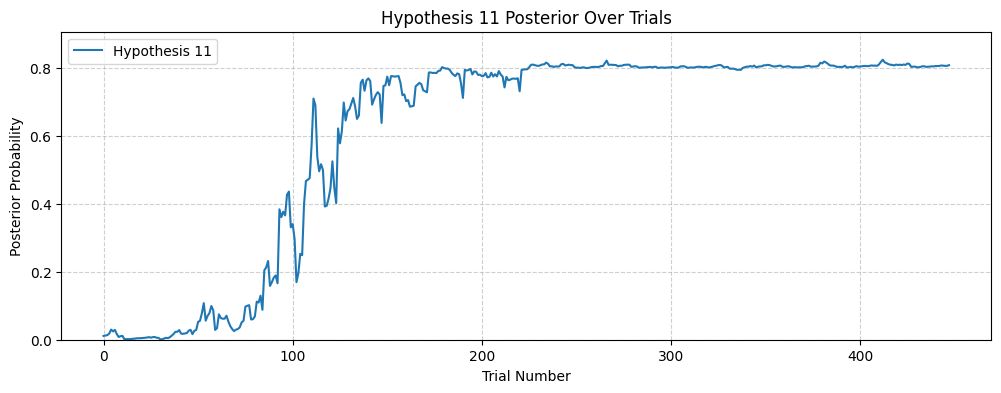

In [110]:
# 画图

import matplotlib.pyplot as plt

def plot_hypo_posterior(posterior_log: list, hypo_index: int, title: str = None):
    
    hypo_posterior_over_time = [posterior[hypo_index] for posterior in posterior_log]
    
    max_post = max(hypo_posterior_over_time)
    trials = np.arange(len(hypo_posterior_over_time))

    plt.figure(figsize=(12, 4))
    plt.plot(trials, hypo_posterior_over_time, linestyle='-', label=f'Hypothesis {hypo_index}')
    
    if title is None:
        title = f'Posterior Probability of Hypothesis {hypo_index} Over Trials'
    plt.title(title)
    plt.xlabel('Trial Number')
    plt.ylabel('Posterior Probability')
    plt.ylim(0, max_post * 1.1)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

hypo_index = 11
plot_hypo_posterior(results_state, hypo_index=hypo_index, title=f"Hypothesis {hypo_index} Posterior Over Trials")